In [1]:
from __future__ import print_function
from __future__ import absolute_import
from __future__ import division
import pickle
import random
import math
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from scipy.stats import pearsonr

In [2]:
data_dir = '../data'

vid_dirs = [
    './data/animations_all/HH/Style1/7',
    './data/animations_all/HH/Style1/10',
    './data/animations_all/HH/Style1/20',
    './data/animations_all/HH/Style1/50',
    './data/animations_all/HH/Style1/100',
    './data/animations_all/HH/Style2/7',
    './data/animations_all/HH/Style2/10',
    './data/animations_all/HH/Style2/20',
    './data/animations_all/HH/Style2/50',
    './data/animations_all/HH/Style2/100',
    './data/animations_all/HO/Style1',
    './data/animations_all/HO/Style2',
    './data/animations_all/HO/Style3',
    './data/animations_all/OO/collision',
    './data/animations_all/OO/rod',
    './data/animations_all/OO/rope',
    './data/animations_all/OO/spring',
]

general_types = [
0,
1,
2,
3,
4,
0,
1,
2,
3,
4,
5,
5,
5,
6,
7,
8,
9
]
markers = {0: 'o', 1: 'o', 2: 'o', 3: 'o', 4: 'o',
           5: '^', 6: 's', 7: 's', 8: 's', 9: 's'}

data_launching = {'names': ['launch', 'entrain', 't_gap', 'trigger','s_gap'],
               'D': [6.89017165133356e-05,  0.023289046103250815, 0.005259762841931694, 0.03874138929580981, 0.004464519393746574],#[6.89017165133356e-05, 0.0218706360819626, 0.005259762841931694, 0.047741875808749966, 0.005994920337276948],
               'L_rotate': [0.22120619786475107, 0.32565163881485054, 0.2106900044872212, 0.24134711706624695, 0.2104925571035405], #[0.18729306302353205, 0.29204702265296223, 0.18409542652255614, 0.18958318637648927, 0.16578788223877636],
               'L_original': [-0.09124865708295316, -0.16419075269020544, -0.07836904865433549, -0.09347373358132133, -0.0989131653069031],
               'L_average': [0.002838192380029921, -0.005557890802044853, 0.002838192380029921, 0.0024844206670662627, 0.0012422103335331313]}

In [3]:
"""load human responses"""
response_file_name = data_dir + '/human_responses_exp1.txt'
HH, OO, HO = [], [], []
with open(response_file_name) as f:
    for line in f:
        res = [float(x) for x in line.split()]
        HH.append(res[0] / sum(res[:3]))
        OO.append(res[1] / sum(res[:3]))
        HO.append(res[2] / sum(res[:3]))
GT_types = []
for vid_type, vid_dir in enumerate(vid_dirs):
    GT_types += [general_types[vid_type]] * 50

In [4]:
"""load and preprocess model results"""
def load_model_results(train_size, model='ours'):
    max_loss = 0.5
    D1, D2, D_all = [], [], [] # deviations of each entity + average of both entities
    L1, L2, L_all = [], [], [] # log-likelihood ratios of each entity + average of both entities
    ll_ratios = pickle.load(open(data_dir + '/{}L_{}.pik'.format('' if model == 'ours' else model + '_', train_size), 'rb'))
    loss_all = [pickle.load(open(data_dir + '/{}D_{}_{}.pik'.format('' if model == 'ours' else model + '_', dataset, train_size), 'rb'))
                for dataset in ['collision', 'spring']]
    for vid_dir in vid_dirs:
        losses = [loss[vid_dir] for loss in loss_all]
        for i, vid_id in enumerate(range(1, 100, 2)):
            if model == 'ours':
                L1_1 = ll_ratios[vid_dir][0][i][0:].mean()
                L1_2 = ll_ratios[vid_dir][1][i][0:].mean()
                L2_1 = ll_ratios[vid_dir][2][i][0:].mean()
                L2_2 = ll_ratios[vid_dir][3][i][0:].mean()
            else:
                L1_1 = ll_ratios[vid_dir][0][i]
                L1_2 = ll_ratios[vid_dir][1][i]
                L2_1 = ll_ratios[vid_dir][2][i]
                L2_2 = ll_ratios[vid_dir][3][i]

            # select the best goal combinations
            best = -1e6
            if L1_1 + L2_1 > best:
                best = L1_1 + L2_1
                L1_mean, L2_mean = L1_1, L2_1
            if L1_1 + L2_2 > best:
                best = L1_1 + L2_2
                L1_mean, L2_mean = L1_1, L2_2
            if L1_2 + L2_1 > best:
                best = L1_2 + L2_1
                L1_mean, L2_mean = L1_2, L2_1
            if L1_2 + L2_2 > best:
                best = L1_2 + L2_2
                L1_mean, L2_mean = L1_2, L2_2
    #         L_all.append(max(0, (L1_mean + L2_mean) * 0.5))
            L_all.append((L1_mean + L2_mean) * 0.5)
            L1.append(L1_mean)
            L2.append(L2_mean)

            # select the best physical configurations
            loss_1, loss_2 = 1e8, 1e8
            min_loss = 1e8
            for D in losses:
                cur_loss = np.array(D[i][0][0:]).clip(0,max_loss).mean() + np.array(D[i][1][0:]).clip(0,max_loss).mean()
                if cur_loss < min_loss:
                    min_loss = cur_loss
                    loss_1, loss_2 = np.array(D[i][0][0:]).clip(0,max_loss), np.array(D[i][1][0:]).clip(0,max_loss)
            D_all.append(0.5 * ((loss_1.mean() + loss_2.mean())))
            D1.append(loss_1.mean())
            D2.append(loss_2.mean())
            
            # find out OO videos with high intention measures
            if L_all[-1] > 0.22 and 'OO' in vid_dir:
                print(vid_dir, vid_id, L_all[-1], D_all[-1])
            
    #         print(vid_id, L1_mean, L2_mean, D1[-1], D2[-1])
    return D1, D2, D_all, L1, L2, L_all

In [5]:
def get_types(D_all, L_all, num_videos_per_type, N, exclude_types=[]):
    """get """
    Ds, Ls = [], []
    HHs, HOs, OOs, colors = [], [], [], []
    types = []
    start = 0
    for vid_type, vid_dir in enumerate(vid_dirs):
        if general_types[vid_type] not in exclude_types:
            types += [general_types[vid_type]] * (50 // N)
            for i in range(0, num_videos_per_type // N):
                Ds.append(sum(D_all[start + i * N : start + (i + 1) * N]) / N)
                Ls.append(sum(L_all[start + i * N : start + (i + 1) * N]) / N)
                cur_OO = sum(OO[start + i * N : start + (i + 1) * N]) / N
                cur_HO = sum(HO[start + i * N : start + (i + 1) * N]) / N
                cur_HH = sum(HH[start + i * N : start + (i + 1) * N]) / N
                OOs.append(cur_OO)
                HOs.append(cur_HO)
                HHs.append(cur_HH)
                colors.append((cur_HH, cur_HO, cur_OO))
        start += num_videos_per_type
    return Ds, Ls, HHs, HOs, OOs, colors, types

In [6]:
def get_viz_datapoints(D_all, L_all, num_videos_per_type, N, exclude_types=[]):
    """get data points for visualization"""
    Ds, Ls = [], []
    HHs, HOs, OOs, colors = [], [], [], []
    types = []
    start = 0
    for vid_type, vid_dir in enumerate(vid_dirs):
        if general_types[vid_type] not in exclude_types:
            types += [general_types[vid_type]] * (50 // N)
            for i in range(0, num_videos_per_type // N):
                Ds.append(sum(D_all[start + i * N : start + (i + 1) * N]) / N)
                Ls.append(sum(L_all[start + i * N : start + (i + 1) * N]) / N)
                cur_OO = sum(OO[start + i * N : start + (i + 1) * N]) / N
                cur_HO = sum(HO[start + i * N : start + (i + 1) * N]) / N
                cur_HH = sum(HH[start + i * N : start + (i + 1) * N]) / N
                OOs.append(cur_OO)
                HOs.append(cur_HO)
                HHs.append(cur_HH)
                colors.append((cur_HH, cur_HO, cur_OO))
        start += num_videos_per_type
    return Ds, Ls, HHs, HOs, OOs, colors, types

In [7]:
"""Visualizing individual stimuli (100% HH + HO + OO)"""
def viz_ind_with_launching(train_size, D_all, L_all, model, data_type='rotate'):
    num_videos_per_type = 50
    N = 1
    Ds, Ls, HHs, HOs, OOs, colors, types = get_viz_datapoints(D_all, L_all, num_videos_per_type, N, exclude_types=[0,1,2,3])
    ms = [markers[type_id] for type_id in types]

    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(111, frameon=True)
    ax.set_xlabel('Dev. from Pred. of Phys. Model', fontsize=18)
    ax.set_ylabel('Intention', fontsize=18)
    s = 20
    i = 0
    for D, L, c, m in zip(Ds, Ls, colors, ms):
        i += 1
        if L > 0.22 and m == 's':
            print(i, D, L, c, m)
        plt.scatter(x=D, y=L,
                    c=np.array(c).reshape(1,-1), s=s, marker=m)
        
    for x, y, name in zip(data_launching['D'], data_launching['L_{}'.format(data_type)], data_launching['names']):
        plt.scatter(x, y, s=100, facecolor=(1, 1, 1), edgecolor=(0, 0, 0),  marker='*')
        if name.startswith('lau') and data_type == 'rotate':
            dy = -0.01
        elif name.startswith('t_') and data_type == 'rotate':
            dy = 0
        else:
            dy = -0.005
        plt.text(x=x + 0.005, y=y + dy, 
                     s=name, fontsize=12, fontweight='bold', color='orange')


    legend_elements = [Line2D([0], [0], marker='s', color='w', label='HH',
                          markerfacecolor=(0.900, 0.2250, 0.0980), markeredgecolor=(0.900, 0.2250, 0.0980), markersize=10),
                      Line2D([0], [0], marker='s', color='w', label='HO',
                          markerfacecolor=(0, 0.6940, 0.1250), markeredgecolor=(0, 0.6940, 0.1250), markersize=10),
                      Line2D([0], [0], marker='s', color='w', label='OO',
                          markerfacecolor=(0, 0.2470, 0.7410), markeredgecolor=(0, 0.2470, 0.7410), markersize=10)]    
    ax.legend(legend_elements, ['Human-Human Response', 'Human-Object Response', 'Object-Object Response'], 
              bbox_to_anchor=(1.02, 0.5), loc=3, borderaxespad=0., fontsize=14)

    # ax.set_xlim(xmin, xmax)
    # ax.set_ylim(ymin, ymax)

    fig.tight_layout()

    fig.savefig('space_individual_with_launching_{}_{}_{}.pdf'.format(data_type, model, train_size))

In [8]:
"""Visualizing centers (all HH + HO + OO)"""
def viz_center_with_launching(train_size, D_all, L_all, model, data_type='original'):
    num_videos_per_type = 50
    N = 50
    Ds, Ls, HHs, HOs, OOs, colors, types = get_viz_datapoints(D_all, L_all, num_videos_per_type, N)

    # get centers
    Ds0 = list(Ds)
    Ls0 = list(Ls)
    colors0 = list(colors)
    Ds, Ls, colors = [], [], []
    ms = []
    for type_id in range(10):
        tmp_D = [D for D, type in zip(Ds0, types) if type == type_id]
        tmp_L = [L for L, type in zip(Ls0, types) if type == type_id]
        tmp_colors = [c for c, type in zip(colors0, types) if type == type_id]
        Ds.append(np.array(tmp_D).mean())
        Ls.append(np.array(tmp_L).mean())
        mean_c = (np.array([c[0] for c in tmp_colors]).mean(), 
                  np.array([c[1] for c in tmp_colors]).mean(), 
                  np.array([c[2] for c in tmp_colors]).mean())
        colors.append(mean_c)
        ms.append(markers[type_id])

    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(111, frameon=True) 
    ax.set_xlabel('Dev. from Pred. of Phys. Model', fontsize=18)
    ax.set_ylabel('Intention', fontsize=18)
    s = 100
    for D, L, c, m in zip(Ds, Ls, colors, ms):
        plt.scatter(x=D, y=L,
                    c=np.array(c).reshape(1,-1), s=s, marker=m)

    legend_elements = [Line2D([0], [0], marker='s', color='w', label='HH',
                          markerfacecolor=(0.900, 0.2250, 0.0980), markeredgecolor=(0.900, 0.2250, 0.0980), markersize=10),
                      Line2D([0], [0], marker='s', color='w', label='HO',
                          markerfacecolor=(0, 0.6940, 0.1250), markeredgecolor=(0, 0.6940, 0.1250), markersize=10),
                      Line2D([0], [0], marker='s', color='w', label='OO',
                          markerfacecolor=(0, 0.2470, 0.7410), markeredgecolor=(0, 0.2470, 0.7410), markersize=10)]    
    ax.legend(legend_elements, ['Human-Human Response', 'Human-Object Response', 'Object-Object Response'], 
              bbox_to_anchor=(1.02, 0.5), loc=3, borderaxespad=0., fontsize=14)

    str_list = ['7%', '10%', '20%', '50%', '100%', '', 'collision', 'rod', 'soft rope', 'spring']
    for id, (x, y, s) in enumerate(zip(Ds, Ls, str_list)):
        dx, dy = 0, 0
        if id == 6:
            dx = 0.005
            dy = -0.01
        if id == 7:
            dx = 0.01
            dy = -0.01
        if id == 8:
            dx = -0.02
            dy = 0.005
        if id == 9:
            dy = -0.005
            dx = 0.01
        if id < 6:
            plt.text(x=x - 0.01, y=y - 0.02, 
                     s=s, fontsize=12, fontweight='bold')
        else:
            plt.text(x=x - 0.002 + dx, y=y + 0.005 + dy, 
                     s=s, fontsize=12, fontweight='bold')
    # ax.set_xlim(xmin, xmax)
    # ax.set_ylim(ymin, ymax)
    
    for x, y, name in zip(data_launching['D'], data_launching['L_{}'.format(data_type)], data_launching['names']):
        plt.scatter(x, y, s=100, facecolor=(1, 1, 1), edgecolor=(0, 0, 0),  marker='*')
        if name.startswith('lau') and data_type == 'rotate':
            dy = -0.01
        elif name.startswith('t_') and data_type == 'rotate':
            dy = 0
        else:
            dy = -0.005
        plt.text(x=x + 0.005, y=y + dy, 
                     s=name, fontsize=12, fontweight='bold', color='orange')

    fig.tight_layout()

#     fig.savefig('space_centers_with_launching_{}_{}_{}.pdf'.format(data_type, model, train_size))

In [9]:
"""Visualizing individual stimuli (100% HH + HO + OO)"""
def viz_ind_launching(train_size, D_all, L_all, model, data_type='rotate'):
    num_videos_per_type = 50
    N = 1
    Ds, Ls, HHs, HOs, OOs, colors, types = get_viz_datapoints(D_all, L_all, num_videos_per_type, N, exclude_types=[0,1,2,3])
    ms = [markers[type_id] for type_id in types]

    fig = plt.figure(figsize=(5, 4))
    ax = fig.add_subplot(111, frameon=True)
    ax.set_xlabel('Dev. from Pred. of Phys. Model', fontsize=18)
    ax.set_ylabel('Intention', fontsize=18)
    s = 20
    i = 0
    NAME = {'launch': 'launching',
            'entrain': 'entraining', 
            't_gap': 'temporal gap', 
            'trigger': 'triggering',
            's_gap': 'spatial gap'}
#     for D, L, c, m in zip(Ds, Ls, colors, ms):
#         i += 1
#         if L > 0.22 and m == 's':
#             print(i, D, L, c, m)
#         plt.scatter(x=D, y=L,
#                     c=np.array(c).reshape(1,-1), s=s, marker=m)
        
    for x, y, name in zip(data_launching['D'], data_launching['L_{}'.format(data_type)], data_launching['names']):
        plt.scatter(x, y, s=100, facecolor=(1, 1, 1), edgecolor=(0, 0, 0),  marker='*')
#         if name.startswith('lau') and data_type == 'rotate':
#             dy = -0.01
#         elif name.startswith('t_') and data_type == 'rotate':
#             dy = 0
#         else:
#             dy = -0.005
        dx = 0.001
        dy = 0
        if name.startswith('lau') and data_type == 'rotate':
            dx = -0.001
            dy = 0.005
        elif name.startswith('tri') and data_type == 'rotate':
            dx = -0.007
            dy = 0.005
        elif name.startswith('t_') and data_type == 'rotate':
            dx = -0.007
            dy = 0.004
        elif name.startswith('s_') and data_type == 'rotate':
            dx = 0.002
            dy = -0.002
        plt.text(x=x + dx, y= y + dy, 
                     s=NAME[name], fontsize=12, fontweight='bold', color='orange')


#     legend_elements = [Line2D([0], [0], marker='s', color='w', label='HH',
#                           markerfacecolor=(0.900, 0.2250, 0.0980), markeredgecolor=(0.900, 0.2250, 0.0980), markersize=10),
#                       Line2D([0], [0], marker='s', color='w', label='HO',
#                           markerfacecolor=(0, 0.6940, 0.1250), markeredgecolor=(0, 0.6940, 0.1250), markersize=10),
#                       Line2D([0], [0], marker='s', color='w', label='OO',
#                           markerfacecolor=(0, 0.2470, 0.7410), markeredgecolor=(0, 0.2470, 0.7410), markersize=10)]    
#     ax.legend(legend_elements, ['Human-Human Response', 'Human-Object Response', 'Object-Object Response'], 
#               bbox_to_anchor=(1.02, 0.5), loc=3, borderaxespad=0., fontsize=14)
    xmin, xmax = -0.005, 0.042 #0.055
    ax.set_xlim(xmin, xmax)
    plt.xticks([])
    plt.yticks([])
#     ax.set_ylim(ymin, ymax)

    fig.tight_layout()
# 
    fig.savefig('space_individual_launching_{}_{}_{}.pdf'.format(data_type, model, train_size))

./data/animations_all/OO/collision 75 0.26272730033178626 0.017965445727313442
./data/animations_all/OO/rod 75 0.3309783702994135 0.016036872811865926
./data/animations_all/OO/rod 85 0.25670355940593936 0.016439004133991512


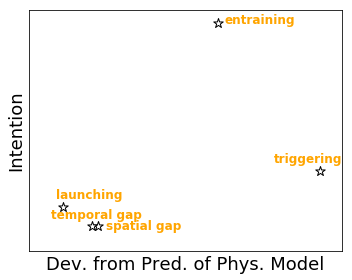

In [10]:
train_size = 50
model = 'ours'
D1, D2, D_all, L1, L2, L_all = load_model_results(train_size, model)
viz_ind_launching(train_size, D_all, L_all, model, data_type='rotate')
